In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import string
from textblob import TextBlob
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


### Our Major Steps/Pipeline will be
1. Data Cleaning
2. EDA
3. Dataset Cleaning/Text Preprocessing
4. Feature Extraction / Vectorization
5. Modeling
6. Evaluation


# Data Cleaning

In [3]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='latin-1')

In [4]:
df.shape

(5572, 5)

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.drop(['Unnamed: 2','Unnamed: 3'	,'Unnamed: 4'],axis=1,inplace=True)

In [7]:
df.rename(columns={'v1': 'spam', 'v2': 'text'}, inplace=True)

In [8]:
df.head()

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['spam'].replace({'ham':0,'spam':1},inplace=True)

In [10]:
df.isnull().sum()

spam    0
text    0
dtype: int64

In [11]:
df.duplicated().sum()

403

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df['n_words']=df['text'].apply(lambda text : len([text for text in word_tokenize(text)]))
df['n_sentences']=df['text'].apply(lambda text : len([text for text in sent_tokenize(text)]))
df['length_sentence']=df['text'].apply(len)

In [14]:
df.head()

,spam,text,n_words,n_sentences,length_sentence
0,0,"Go until jurong point, crazy.. Available only ...",23,2,111
1,0,Ok lar... Joking wif u oni...,8,2,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,2,155
3,0,U dun say so early hor... U c already then say...,13,1,49
4,0,"Nah I don't think he goes to usf, he lives aro...",15,1,61


# EDA

In [15]:
df['spam'].value_counts()

0    4516
1     653
Name: spam, dtype: int64

### Remarks: Data is imbalanced

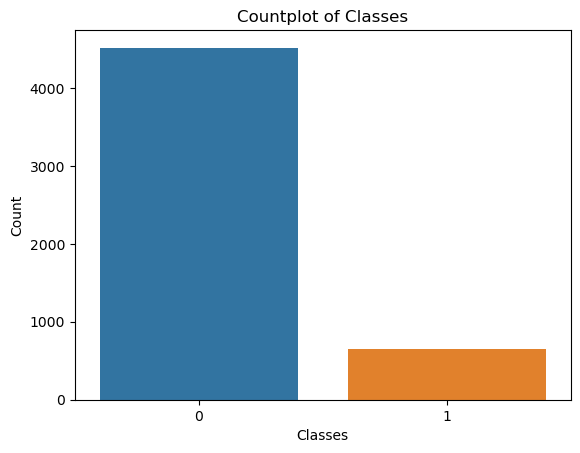

In [16]:
sns.countplot(x='spam', data=df)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Countplot of Classes')
plt.show()

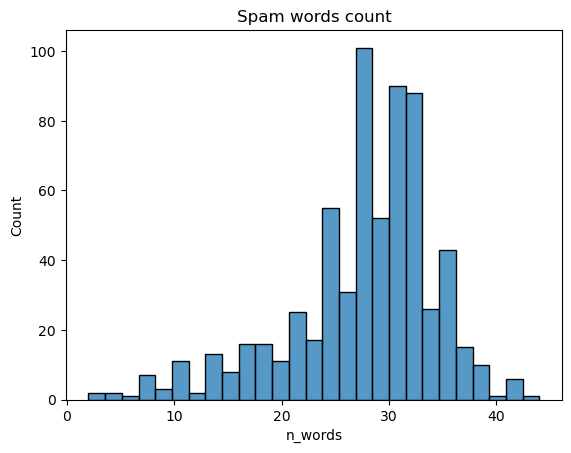

In [17]:
sns.histplot(df[df['spam']==1]['n_words']) # histogram for label 1
plt.title('Spam words count')
plt.show()

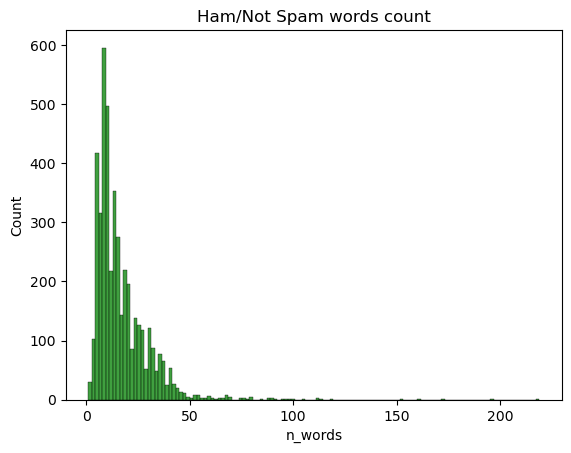

In [18]:
sns.histplot(df[df['spam']==0]['n_words'], color='green') # histogram for label 0
plt.title('Ham/Not Spam words count')
plt.show()

### We will plot the wordcloud and bar plot after text processing so we get better result

# Data Preprocessing

In [20]:
shorthand_dict = {
    "u": "you",
    "r": "are",
    "2": "to",
    "b": "be",
    "gr8": "great",
    "thx": "thanks",
    "btw": "by the way",
    "lol": "laugh out loud",
    "4":"for",
    "w8":"wait",
    "n't":"not",
    '"':"",
    "m":"am",
    "'m'":"am",
    "txt":"text",
    "'s'":"",
    "ur":"your"
    # Add more entries as needed
}

def expand_shorthand(word):
    expanded_word = shorthand_dict.get(word, word)  # Get the expanded word or use the original if not found
    return expanded_word

def clean_words(text):
    text = text.lower()
    text = text.replace("...", "")  # Remove "..."
    
    sentences = sent_tokenize(text)
    sw = set(stopwords.words('english'))
    stemmer = PorterStemmer()  # Initialize the stemmer
    
    list_words = [word_tokenize(sentence) for sentence in sentences]
    
    cleaned_words = [
        re.sub(r'-(?=\w)', ' ', stemmer.stem(expand_shorthand(word)))
        for words in list_words
        for word in words
        if word not in sw and word not in string.punctuation
    ]
    
    return " ".join(cleaned_words)


In [21]:
df['cleaned_text']=df['text'].apply(clean_words)

In [22]:
from wordcloud import WordCloud
word_count = WordCloud(width=1000,height=800,min_font_size=12,background_color='black')

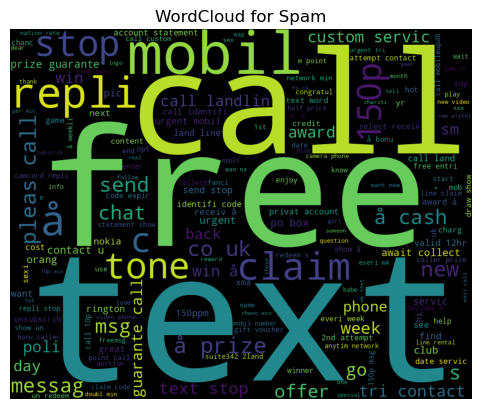

In [23]:
word_count_spam = word_count.generate(df[df['spam'] == 1]['cleaned_text'].str.cat(sep=" ")) # Generating for spam
plt.imshow(word_count_spam)
plt.axis('off')
plt.title('WordCloud for Spam')
plt.show()

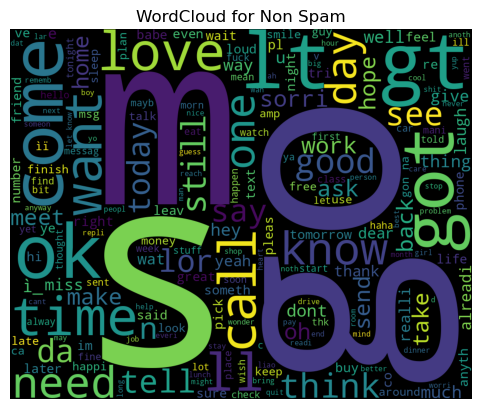

In [24]:
word_count_spam = word_count.generate(df[df['spam'] == 0]['cleaned_text'].str.cat(sep=" ")) # Generating for spam
plt.imshow(word_count_spam)
plt.axis('off')
plt.title('WordCloud for Non Spam')
plt.show()

In [25]:
spam_corpus = [word  for text in df[df['spam'] == 1]['cleaned_text'].tolist() for word in text.split()]
ham_corpus =  [word  for text in df[df['spam'] == 0]['cleaned_text'].tolist() for word in text.split()]
print(len(ham_corpus), len(spam_corpus))

38428 11211


In [26]:
from collections import Counter # Counter will be used to make the dictionary of words as keys and their frequencies as values
# We are doing this because we want to obtain 20 or 30 most frequent words and want to plot them
spam_dict=Counter(spam_corpus)
ham_dict=Counter(ham_corpus)

In [27]:
spam_dataFrame=pd.DataFrame(spam_dict.most_common(20))
ham_dataFrame=pd.DataFrame(ham_dict.most_common(20))

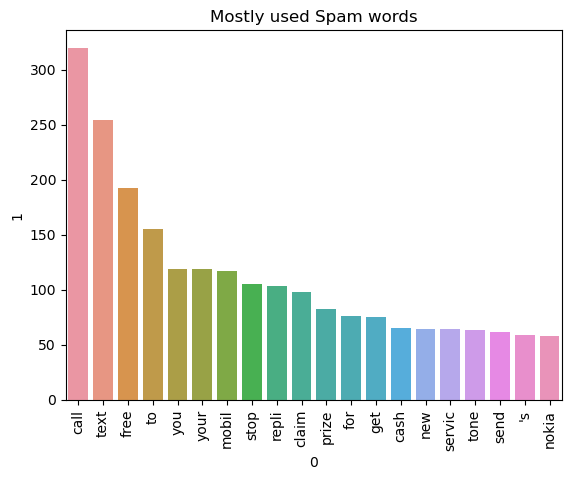

In [28]:
sns.barplot(x=spam_dataFrame[0],y=spam_dataFrame[1])
plt.xticks(rotation='vertical')
plt.title('Mostly used Spam words')
plt.show()

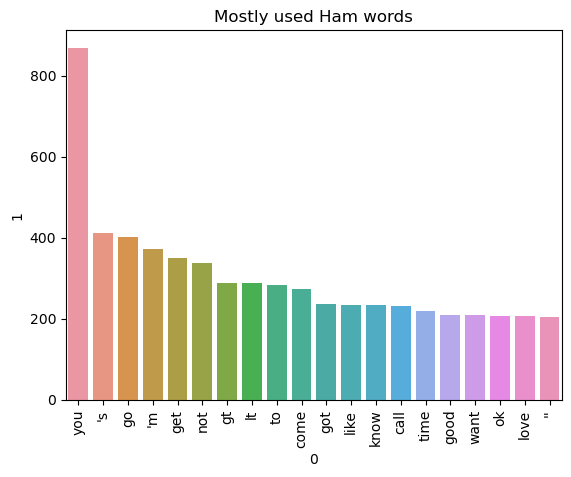

In [29]:
sns.barplot(x=ham_dataFrame[0],y=ham_dataFrame[1])
plt.xticks(rotation='vertical')
plt.title('Mostly used Ham words')
plt.show()

# Vectorizing / Feature Extraction

### Using TFIDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf_vectorizer = TfidfVectorizer()

In [32]:
x=df['text']
y=df['spam']

In [33]:
x_tfidf = tfidf_vectorizer.fit_transform(x).toarray()

## Balancing the dataset

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
smote = SMOTE(sampling_strategy=0.5,random_state=42)
x_res, y_res = smote.fit_resample(x_tfidf, y)

In [36]:
y_res.value_counts()

0    4516
1    2258
Name: spam, dtype: int64

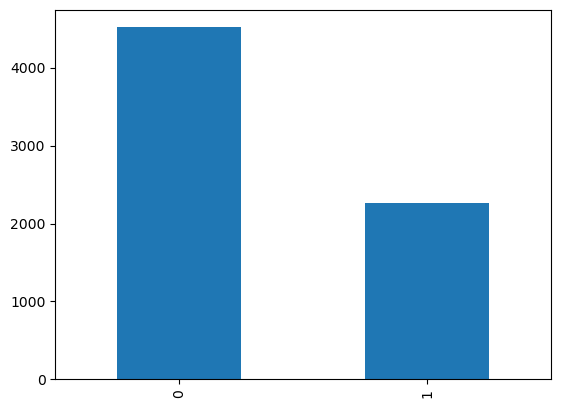

In [37]:
y_res.value_counts().plot(kind='bar')
plt.show()

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,train_size=0.9,random_state=42)

In [40]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [41]:
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
lr = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [42]:
algos={
    'MNB':mnb,
    'GNB':gnb,
    'BNB':bnb,
    'SVC':svc,
    'KNC':knc,
    'LR':lr,
    'DTC':dtc,
    'RFC':rfc,
    'ABC':abc,
    'XGB':xgb,
    'BC':bc,
    'ETC':etc
}

In [43]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [45]:
prec_acc={}
for name , algo in algos.items():
  algo.fit(x_train,y_train)
  ypred=algo.predict(x_test)
  prec_acc[name]={
                      'Precision':precision_score(y_test,ypred),
                      'Accuracy': accuracy_score(y_test,ypred)
                 }

In [46]:
prec_acc

{'MNB': {'Precision': 0.9910714285714286, 'Accuracy': 0.9882005899705014},
 'GNB': {'Precision': 0.8533834586466166, 'Accuracy': 0.9410029498525073},
 'BNB': {'Precision': 1.0, 'Accuracy': 0.9837758112094396},
 'SVC': {'Precision': 0.9955555555555555, 'Accuracy': 0.9926253687315634},
 'KNC': {'Precision': 1.0, 'Accuracy': 0.9646017699115044},
 'LR': {'Precision': 0.972972972972973, 'Accuracy': 0.9734513274336283},
 'DTC': {'Precision': 0.9569377990430622, 'Accuracy': 0.9454277286135693},
 'RFC': {'Precision': 1.0, 'Accuracy': 0.9852507374631269},
 'ABC': {'Precision': 0.9605263157894737, 'Accuracy': 0.9734513274336283},
 'XGB': {'Precision': 0.995475113122172, 'Accuracy': 0.9867256637168141},
 'BC': {'Precision': 0.9732142857142857, 'Accuracy': 0.976401179941003},
 'ETC': {'Precision': 1.0, 'Accuracy': 0.9896755162241888}}

# Result
## Almost all the algorithms have performed well , we can choose any but we can take ExtraTreeClassifier model because of its Precision as 1.

In [47]:
prec_acc['ETC']['Precision']

1.0

In [49]:
prec_acc['ETC']['Accuracy']

0.9896755162241888